<a href="https://colab.research.google.com/github/hhaller0826/ci2-fairness-ncm/blob/main/IntroFairnessNCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction/Explanation

Causal Inference [***TODO***: briefly explain the field of study & purpose of the notebook, especially as it relates to non-causal researchers]

---

### Table of Contents
**Section 1: Create a Causal Graph** 
This will walk you through creating a graph to represent relationships between the variables you plan to analyze. 

**Section 2: Train the Model**
This will walk you through creating a neural causal model, and training it to learn the relationships that are represented in your causal graph based on your data.

**Section 3: Extract Causal Insights from the Model**
This will provide instructions for extracting information about the causal relationships in your trained model. This may contain useful tools for your analysis, but does not contain any steps that are necessary for progressing to Section 4.

**Section 4: Project onto the Standard Fairness Model**
This will walk you through projecting your trained model onto a standard fairness model, which can then be used to perform fairness analysis. Note that the tools for extracting metrics described in Section 3 can also be applied to the resulting standard fairness model. 

**Section 5: Run Fairness Tasks** 
This will walk you through using your Standard Fairness Model projection to perform bias detection, fair prediction, and fair decision-making.

In [1]:
# Run this cell before you progress to ensure this notebook has access to the necessary code.
import pandas as pd
from src.utilities import *
from src.graph.utils import *
from src.graph.causal_graph import CausalGraph
from src.training.train import *
from src.metric.probabilities import ReusableProbability
from src.metric.queries import *
from src.model.sfm import SFM
from src.fairness.task1 import FairnessCookbook
from src.fairness.task2 import *

# Create a Causal Graph

A causal graph (or "causal diagram") represents the relationships between the features in your data. Each node on the graph may represent one or more of these features, though the name of the node does *not* need to correspond to the data column that it will represent. Please note that if a single node represents multiple features, we will not be able to distinguish between these features when doing causal analysis. 

If the values in one node may impact the values in another node, the graph will have a directed edge from the first node to the one that it affects. 

Sometimes there are confounders between two variables (lets call them A and B), meaning they are both directly impacted by the same third variable C. If C is one of the nodes on your graph, then there will be one directed edge from C to A, and another from C to B. If C is *not* one of the nodes on your graph, then we will create a bi-directed edge between A and B to signify that they are confounded. 

Examples of some graphs:

![](img/default_graphs.png)

### Define your graph below.

You can use one of the pre-defined graphs, like so:
```
my_graph = get_predefined_graph(type='____')
```
Valid types include `simple`, `bow`, `frontdoor`, `backdoor`, `napkin`, and `sfm`. 


Alternatively, you create your own graph. Here is an example:
```
nodes = ['W', 'X', 'Y', 'Z']
edges = [('X', 'Y'),
        ('X', 'W'),
        ('Z', 'Y'),
        ('Z', 'W'),
        ('W', 'Y'),
        ('X', 'Z', 'bidirected'),
        ('Z', 'Y', 'bidirected')]

my_graph = CausalGraph(nodes=nodes, edges=edges)
```

*Remember*: when defining the directed, the arrow goes from the first node to the second one. So for example, ```edges = [('X', 'Y')]``` indicates one edge going from 'X' to 'Y'. When defining a bidirected edge, it does not matter which direction nodes are listed, but you must add the key term `'bidirected'` after listing the two nodes.

In [2]:
# OPTION 1 -- using a pre-defined graph:
my_graph = get_predefined_graph('backdoor')

# OPTION 2 -- using a custom graph (delete this if you pick option 1): 
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] # Node names do not need to correspond to the names of your data columns. 
bidirected_edges = [
    ('C', 'A'),
    ('F', 'A'),
]
directed_edges = [
    ('A', 'B'),
    ('A', 'D'),
    ('A', 'E'),
    ('A', 'G'),
    ('C', 'B'),
    ('C', 'D'),
    ('C', 'E'),
    ('C', 'G'),
    ('F', 'B'),
    ('F', 'D'),
    ('F', 'E'),
    ('F', 'G'),
    ('B', 'G'),
    ('D', 'G'),
    ('E', 'G'),
]

my_graph = CausalGraph(nodes, directed_edges, bidirected_edges)

Double-check that this is the graph you want:

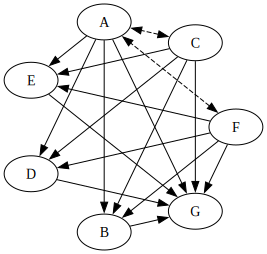

In [3]:
my_graph.plot(scale=1.5)
# Note: Currently, if you add too many nodes with long names, it may throw an error.
# In this case, try reducing the names of the nodes to 3 characters or less, or reduce the number of nodes in your graph.

# Train the Model

### Complete the Structural Causal Model
Now that you have defined the graph we have the variables and dependencies, but we still need to learn the relationships between these variables to understand the causal mechanisms at work.

These relationships will be learned based on your data, so we will start by processing your data file. This happens in the following order:
1. Load your data as a `DataFrame` object. If it is a csv file, you can just replace the filename in the code below and your data will be loaded properly. 
2. Once loaded, you can alter the data if needed before continuing with processing. The default processing functions will handle converting categorical data and other standard tasks, but if, for example, you want one of the features to be converted into binary value, you will have to do that here.
3. Specify which features in your data have categorical values, and which have discrete values. The default data processing will assume that all discrete variables can be rounded to whole numbers. 
4. **Assign features**: As stated above, the nodes of your graph need not correspond to the corresponding data features. You will instead manually define that correspondance here, in the following format: 
    ```
    assignments = {
        'node_1': ['data_feature', 'data_feature', ...],
        'node_2': ['data_feature', 'data_feature', ...],
        ...
    }
    ```
    If a node only has one corresponding feature, you would assign it like so: `'node': ['data_feature']`.

    Assignments have the following restrictions:
    * All nodes you assign must be present in the graph above, and every node in the graph must have an assignment. Empty assignments will not be accepted. 
    * Each data feature can only be assigned to a single node. 
    * Each data feature *must* be present in the `DataFrame` object you created in step (1). 
    It is ok if some of your data features are excluded from the model, but any excluded features will not be used in the subsequent causal analysis. 


In [4]:
# Load the CSV file with your data:
df = pd.read_csv('data/compas-scores.csv')

# Do any special pre-processing that you may want to do (this is optional):
df['race'] = df['race'].apply(lambda x: int(x=='Caucasian'))

# Specify which features in your data are categorical, and which are discrete. 
categorical = ['race', 'age_cat', 'r_charge_degree', 'sex', 'score_text', 'is_recid']
discrete = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# Now define which columns of your data correspond to each node in your graph:
assignments = {
    'A': ['race'],
    'B': ['juv_fel_count', 'juv_misd_count', 'juv_other_count'],
    'C': ['age'],
    'D': ['priors_count'],
    'E': ['r_charge_degree'],
    'F': ['sex'],
    'G': ['is_recid']
}

# Process data & assignments
my_data = process_data_assignments(df, assignments, my_graph, categorical, discrete)
my_data.print_df()


It is okay to exclude features from the model but they will not be used in the causal analysis.


/Users/Hanita/causal/ci2-fairness-ncm/src/utilities.py:81: UserWarning: The following features were not assigned to any variable: {'is_violent_recid', 'age_cat', 'vr_offense_date', 'v_screening_date', 'c_charge_degree', 'v_type_of_assessment', 'days_b_screening_arrest', 'id', 'decile_score', 'decile_score.1', 'c_case_number', 'c_days_from_compas', 'dob', 'r_case_number', 'v_decile_score', 'r_charge_desc', 'r_offense_date', 'type_of_assessment', 'name', 'screening_date', 'r_days_from_arrest', 'vr_charge_desc', 'v_score_text', 'first', 'r_jail_in', 'vr_charge_degree', 'c_jail_in', 'c_offense_date', 'compas_screening_date', 'c_charge_desc', 'num_r_cases', 'num_vr_cases', 'vr_case_number', 'score_text', 'r_jail_out', 'last', 'c_arrest_date', 'c_jail_out'}
  warnings.warn('The following features were not assigned to any variable: {}'.format(unassigned_features), UserWarning)


,race,juv_fel_count,juv_misd_count,juv_other_count,age,priors_count,r_charge_degree,sex,is_recid
6107,0.0,0.0,0.0,0.000000,0.141026,0.000000,0.5,1.0,1.0
6463,0.0,0.0,0.0,0.000000,0.205128,0.046512,1.0,1.0,0.5
6560,1.0,0.0,0.0,0.176471,0.012821,0.000000,1.0,1.0,0.5
1396,0.0,0.0,0.0,0.000000,0.576923,0.069767,1.0,1.0,0.5
4003,0.0,0.0,0.0,0.000000,0.115385,0.023256,1.0,0.0,0.5


***TODO***: fill out model instructions. This will vary depending on whether I am able to implement more than just FF_NCM. 

***TODO***: multiple distribution options. 

When training the network, you are able to manually adjust various settings called "hyperparameters". These include the following:
* `pipeline_choice`: this specifies the type of neural network that will be ran. The options are as follows,
    * `'mle'`: Maximum Likelihood Estimator
    * `'gan'`: Generative Adversarial Network
    * `'ffn'`: Feed Forward Network
    The default is 'mle'. 
* `n-epochs`: the number of epochs, or passes through the dataset to complete during the training phase, to run. Default: 1000. 
* `batch-size`: number of training examples to use in each training epoch. 
* `gpu`: the GPU to use, if you have one. Default: none

You may set some, none, or all of these values manually. Valid definitions include:
```
hyperparameters = {
    'pipeline_choice': 'gan',
    'n-epochs': 500
}
```
```
hyperparameters = {}
```
```
hyperparameters = {
    'pipeline_choice': 'ffn',
    'n-epochs': 4600,
    'batch-size': 4,
    'gpu': gpu
}
```

In [5]:
# Set your parameters here: # TODO
hyperparameters = {
    'model_choice': 'gan',
    'distribution': 'uniform',
    'nn': 'mlp',
    'device': 'cpu',
    'n-epochs': 2,
    'learning-rate': 1e-3,
    'optimizer': None
}

# And train the model:
my_model = get_ncm(my_graph, assignments, scale=my_data.get_assigned_scale())
_ = train_ncm(my_model, my_data, hyperparameters=hyperparameters)

Epoch 1/2, Loss: 0.1352
Epoch 2/2, Loss: 0.0896


# Extract Causal Insights from the Model
Now that you have a trained model, you can use it to evaluate cause-effect relationships in your data. The metrics that you can evaluate are split into three categories: (1) values that can be computed directly from the data, (2) values that would occur if you force a variable to take on a certain value, and (3) questions about what would have happened in an imaginary world where some observed facts are bluntly negated.

### Observational Understanding
Observational metrics can be calculated directly from the data. These include calculating standard probabilities and conditional probabilities (ex.: $P(Y=1)$ or $P(Y=1|X=0)$), as well as something called the "total variation".

*Total Variation (TV)*: a measure of how much the probability distribution of some variable $Y$ is impacted by the observed value of a given attribute $X$. If possible values of $X$ are $x_0, x_1$ then the Total Variation can be calculated by the equation below.
$$TV_{x_0,x_1}(y) = P(Y=y|X=x_1)-P(Y=y|X=x_0)$$

The available observational measures are defined as follows:
* `probability(model, variable, value, evidence)`: This will calculate the probability that a variable equals a certain value given the dictionary of evidence. The dictionary of conditional evidence is optional.
    * `probability(model, 'Y',1)` will return $P(Y=1)$
    * `probability(model, 'Y',1,{'X':0,'Z':2})` will return $P(Y=1|X=0,Z=2)$
* `total_variation(model, variable, value, attr, aval0, aval1)` will return the total variation of the given variable relative to the given attribute. $TV_{aval0,aval1}(variable=value)$. `avail1` is an optional value, and will default to "not avail0" if left blank. 
    * `total_variation(model,'Y',1,'X',x0,x1)` will return $TV_{x_0,x_1}(Y=1) = P(Y=1|X=x_1)-P(Y=1|X=x_0)$
    * `total_variation(model,'Y',1,'X',x0)` will return $TV_{x_0,x_1}(Y=1) = P(Y=1|X=x_1)-P(Y=1|X\neq x_1)$

In [6]:
prob = ReusableProbability(my_model, 'G', 'A', 1)
prob.total_variation(1)
total_variation(my_model, 'G', 1, 'A', 1)

TV(G=1) = 0.3382 - 0.3604 = -0.0222
TV(G=1) = 0.3387 - 0.3741 = -0.0355


-0.03548100994755232

### Interventional Metrics
Interventional metrics arise when you actively say "what if we force this variable to take on a certain value?"
The difference between a conditional probability ($P(Y|X=x)$) and an interventional one ($P(Y|do(X=x))$) is that when you force an event to happen, you emancipate it from all other influences. [kinda stole this wording from the book of why but not exactly...]

*For example*: say that patients who go to the doctor for a certain illness all recieve advice and prescription medication, and this allows them to heal within a week. Say that those who have not recieved the advice nor the medication don't heal so quickly.

![](img/dr_advice_meds_healed.png)

If we are trying to evaluate the likelihood that someone has healed, and we observe that they have recieved the advice, we can assume from our data that they went to the doctor and recieved medication too. 

Essentially, {patient got advice} $\implies$ {patient went to doctor} $\implies$ {patient got advice} AND {patient got medication}

This means that $P(\text{healed} | \text{advice})=P(\text{healed} | \text{advice},\text{medication})$.

But what if a patient hears the doctor's advice from a friend? In this case, even though the patient has heard the advice, they may not have seen the doctor, and they may not have access to the medication. This is an example of an intervention. Although we can usually assume that someone who has heard the advice has seen a doctor, the friend intervened and gave the patient advice, so even though we know the patient has heard the advice, we don't have any knowledge of whether or not they went to a doctor and recieved medication. Here, $P(\text{healed} | do(\text{advice}))\neq P(\text{healed} | \text{advice})$.

*Total Effect (TE)*: Similar to Total Variation, except these variations represent changes in behavior based on the value of $X$, rather than comparing the naturally arising distribution based on $X$. 

$$TE_{x_0,x_1}(y) = P(Y=y | do(X=x_1)) - P(Y=y | do(X=x_0))$$

*z-Total Effect (z-TE)*: Total Effect with an additional observational condition. We intervene to force $X=\{some-value\}$, and we add the condition that some other variable $Z$ was observed to be $z$. 

$$z\text{-}TE_{x_0,x_1}(y) = P(Y=y | do(X=x_1), Z=z) - P(Y=y | do(X=x_0), Z=z)$$

The available interventional measures are defined as follows:
* `probability(model,variable, value, evidence, intervention)`: This will calculate the probability that a variable equals a certain value given the dictionary of evidence, and the dictionary of interventions. Both dictionaries are optional.
    * `probability(model,'Y',1,{'X':0},{'Z':1})` will return $P(Y=1 | X=0, do(Z=1))$
    * `probability(model,'Y',1,intervention={'Z':1})` will return $P(Y=1 | do(Z=1))$
* `total_effect(model, variable, value, attr, aval1, aval0, evidence)` 
    * `total_effect(model, 'Y', 1, 'X', 1, 0)` will return $P(Y=1 | do(X=1)) - P(Y=1 | do(X=0)) = TE_{0,1}(y)$
    * `total_effect(model, 'Y', 1, 'X', 1, 0, evidence={Z:z})` will return $P(Y=1 | do(X=1),Z=z) - P(Y=1 | do(X=0),Z=z) = z$-$TE_{0,1}(y)$

In [7]:
prob.total_effect(1, x1=1, x0=0)
total_effect(my_model, 'G', 1, 'A', 1, 0)

TE(G=1) = 0.3290 - 0.3624 = -0.0334
TE(G=1) = 0.3379 - 0.3738 = -0.0359


-0.03590000000000004

### What-ifs
Lastly we can evaluate "counterfactuals", named because it is the probability of something that we have no real world data on. 

For example, say people have the option to take a medication or heal naturally, and that the observational data shows that individuals who healed naturally actually survived longer on average. Is this because the medication was harmful, or is it because the *types* of people who decided to heal naturally were typically younger, healthier, had fewer comorbidities, or had fewer symptoms to begin with? 

What is the probability that someone who opted out of medication would have healed had they taken it? What is the probability that someone who decided to take medication would have healed if they never got it? 

These are "counterfactual" questions because to answer them we would have to go back in time and change history. There is no experiment that can deny treatment to an already treated person and compare the two outcomes. 

#### New notation: $P(Y_X)$

$P(Y_{X=x})$ is the same as saying "probability of $Y$ intervened on to force $X=x$". In the section above, this was denoted $P(Y|do(X=x))$. However when written with this notation, we are stating that the intervention $do(X=x)$ only applies to $Y$. 

If another variable in the model, $Z$, is also affected by $X$, then when calculating $P(Y|do(X=x),Z=z)$, the intervention $X=x$ will be applied to both $Y$ and $Z$. Conversely, when evaluating the term $P(Y_{X=x}|Z=z)$, the intervention is only applied to $Y$, and $Z$ will be calculated based on the unaffected/real $X$ values. 

#### Counterfactual Quantities:

*Effect of Treatment on the Treated (ETT)*: evaluate whether people who gained access to treatment would have had the same outcome if they had never recieved it.
$$ETT_{x,x'}(Y)=P(Y_{X=x}=y | X=x')$$

*Probability of Necessity (PN)*: encodes how much the presence of a value $X$ was a *necessary* cause to make $Y=1$.
$$PN(X;Y)=P(Y_{X=0}=0|X=1,Y=1)$$

*Probability of Sufficiency (PS)*: encodes how much the presence of a value $X$ was *sufficient* to make $Y=1$.
$$PS(X;Y)=P(Y_{X=1}=1|X=0,Y=0)$$

Both of the above translate to "in a situation where $X=x$ and $Y=y$, what is the probability that the value of $Y$ would have been different if you had changed the value of $X$?" These can be combined into 
$$PN/PS_{(x,y)(x',y')}(X;Y) = P(Y_{X=x}=y | X=x', Y=y')$$


The available counterfactual measures are defined as follows:
* `ett(outcome_var, outcome_val, treatment_var, treatment_vals={'actual':_, 'whatif':_})`: This will calculate the probability of a given outcome if we had intervened to change the treatment. In the `treatment_vals` dictionary, you must specify either `actual` or `whatif`, but you do not need to specify both. 
  * `ett('Y',1,'X',{'actual':0, 'whatif':1})` will return $P(Y_{X=1}=1|X=0)$, which is the probability that $Y=1$ if we had intervened to make $X=1$, given that $X$ was actually 0.
  * `ett('Y',1,'X',{'whatif':1})` will return $P(Y_{X=1}=1|X\neq 1)$, which is the probability that $Y=1$ if we had intervened to make $X=1$, given that $X$ was not actually 1.
  * Note: the "whatif" value must be specified so `treatment_vals={'actual':_}` is not a valid input.

* `pnps(outcome_var, outcome_vals={'actual':_, 'whatif':_}, treatment_var, treatment_vals={'actual':_, 'whatif':_})` 
  * `pnps('Y', outcome_vals={'actual':0, 'whatif':1}, 'X', treatment_vals={'actual':0, 'whatif':1})` will return the probability that $Y=1$ if we had intervened to make $X=1$, given that $Y$ and $X$ were actually both 0. 
  * Note: like with ETT, the "whatif" values must be explicitly stated in both `outcome_vals` and `treatment_vals`, but the "actual" values may be assumed. 


In [8]:
outcome_vals = {
    'actual': 0,
    'whatif': 1
}
treatment_vals = {
    'whatif': 1
}
prob.pnps(outcome_vals['whatif'], outcome_vals['actual'], treatment_vals['whatif'])
pnps(my_model, 'G', outcome_vals, 'A', treatment_vals, assignments)

0.0021: probability that G=1 if we had intervened to make A=1, given that G was not actually 1 and A was not actually 1.
0.0011: probability that G=1 if we had intervened to make A=1, given that G was not actually 1 and A was not actually 1.


0.0011299435028248588

In [9]:
prob.ett(1, whatif_treatment=treatment_vals['whatif'])
ett(my_model, 'G', 1, 'A', treatment_vals)

0.3241: probability that G=1 if we had intervened to make A=1, given that A was not actually 1.
0.3320: probability that G=1 if we had intervened to make A=1, given that A was not actually 1.


0.33196072220462464

# Project onto the Standard Fairness Model

The standard fairness model (SFM) is a model whose graph has four nodes:
* $X$: The protected attribute. When doing fairness analysis, we are trying to figure out whether or not an outcome is fair with respect to this attribute. (Ex.: race)
* $Z$: The counfounding variables. These variables are not causally influenced by the protected attribute $X$, but may be correlated in some way. (Ex.: demographic information, zip code)
* $W$: The mediator variables. Variables which may be causally influenced by the protected attribute. (Ex.: education-level, prior employment)
* $Y$: The outcome variable. (Ex.: admissions, hiring decisions, salary)

When projecting onto the SFM, you should select one of your model's variables to be $X$ and one to be $Y$, but you may assign multiple variables as confounders or mediators. Counfounders may have any relationship to the other confounders, and mediators may have any relationship with the other mediators, however there is a specific structure that must exist between $X$, $Z$, $W$, and $Y$:
* $Y$ must be a variable that has 0 arrows pointing toward $X$, $Z$, or $W$.
* $W$ must contain variables that have 0 arrows pointing toward $X$ or $Z$.
* $X$ and $Z$ cannot have arrows pointing towards each other, but they may have a bidirected arrow between them. 

**Here is an example**:
Given the following graph. 

![example1graph.png](img/example1graph.png)

Based on this graph, you could do either of the following projections:
```
projection1 = {
    'X': 'e',
    'Z': ['a', 'b'],
    'W': ['c', 'd'],
    'Y': 'f'
}
```

or 
```
projection2 = {
    'X': 'a',
    'Z': ['e'],
    'W': ['b', 'c', 'd'],
    'Y': 'f'
}
```

![](img/ex1projection1.png) ![](img/ex1projection2.png)

The following would **not** be a valid projection: 
```
bad_projection = {
    'X': 'a',
    'Z': ['b', 'e'],
    'W': ['c', 'd'],
    'Y': 'f'
}
```
because there is an arrow from the `X` variable (containing `'a'`) to the `Z` variable (containing `'b'`). This indicates that `X` may actually cause `Z`, rather than just being confounded with `Z`. 

In [10]:
# Specify your projection here:
projection = {
    'X': 'A',
    'Z': ['C', 'F'],
    'W': ['E','D','B'],
    'Y': 'G'
}

sfm = SFM(my_model, projection, my_data) 
# Ensure this was the projection you were expecting:
sfm.print_projection()


Protected Attribute: ['race']
Confounders:         ['age', 'sex']
Mediators:           ['r_charge_degree', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
Outcome:             ['is_recid']


# Run Fairness Tasks

(This will have a lot of the same tasks & suggestions as Drago's git thinggy https://dplecko.github.io/CFA/)

Most fairness analysis can be split into three general tasks: (1) bias detection and quantification, (2) fair prediction, and (3) fair decision-making.

### Task 1: Bias Detection & Quantification
Here we will evaluate "fairness measures" which can determine whether discrimination is present within a dataset, and indicate how strong that discrimination is.

1. *Direct Effect (DE)* indicates whether your protected attribute *X* is directly impacting your outcome variable *Y*. 

2. *Indirect Effect (IE)* indicates whether your outcome variable is being indirectly impacted by your protected attribute. 

For example, if *X* denotes race and *Y* denotes whether a candidate was hired, "direct effect" would indicate whether two identical candidates of different races would have the same likelihood of being hired, whereas "indirect effect" would indicate that a candidate's race impacts some other attribute (like education level, prior job experience, etc.) which in turn impacts salary.

3. *Spurious Effect (SE)* indicates whether there are variables that causally affect both your outcome variable and protected attribute, causing them to be correlated. 

Race causally affects an individual's hair color (if they are not of European descent, then there is an incredibly high likelihood that they will have black hair). If race also affects whether a candidate is hired (directly or indirectly), then there will be a spurious effect of hair color on salary, even though hair color itself does not directly or indirectly impact a candidate's salary. 

When thinking about bias, we typically think about how some attribute $X$ impacts a decision or prediction $Y$. If the direct effect is non-zero, then there is evidence of disparate *treatment* in the outcome $Y$, meaning $X$ is being used in the decision process. 

If the indirect or spurious effects are non-zero, then there is evidence of disparate *impact*, which typically refers to cases where discrimination is unintended or implicit. Sometimes it is not possible to eliminate disparate impact. For example, if there is discrimination in the educational system, and a job requires a certain level of education, then they may hire more people of a certain demographic simply because more people from that demographic have the necessary qualifications. This is known as *business necessity*. 

The `fairness_cookbook` below will calculate bias detection information based on the Standard Fairness Model projection you created above. Note that you will need to define an $x_0$ and $x_1$ value, just like you did when calculating the $ETT$. 

In [11]:
# create your cookbook
fcb = FairnessCookbook(sfm=sfm, x0_val=0, x1_val=1)

# Get your data:
fcb.fairness_cookbook()
fcb.x_specific_effects()

xDE^sym = -0.1070±0.0365	 hypothesis H^xDE=0 REJECTED
	 ---> evidence of disperate TREATMENT.
xIE^sym = 0.0090±0.0365	 hypothesis H^xIE=0 ACCEPTED
xSE_x1x0 = 0.0221±0.0309	 hypothesis H^xSE=0 ACCEPTED
	 ---> no evidence of disperate IMPACT.

xTE_x0x1(Y=1 | X=0) = -0.0355
xDE^sym(Y=1 | X=0) = -0.0379
xIE^sym(Y=1 | X=0) = 0.0024
xSE_{'X': 1},{'X': 0}(Y=1) = -0.0258
TV_{'X': 0},{'X': 1}(Y=1) = -0.0097


### Task 2: Fair Prediction 
The goal of "Fair Prediction" tasks is to construct a predictor $\hat{Y}$ of $Y$, which is also a function of $X$, $Z$, and $W$, but does not carry over any bias from the existing data. This is achieved by ensuring $\hat{Y}$ satisfies some kind of "fairness constraint". 

As stated above, these predictors don't always have to be "fair" with respect to every single attribute. For example, say a hospital is building a predictor to scan through applications and predict whether the candidate will be a good Doctor. They will likely include education status as a mediator variable, however the predictor should not be "fair" with respect to educational status. While gender bias and racial discrimination should be eliminated from the model, the hospital needs to maintain a strict bias against anyone who has not completed medical school. This is what's known as a "Business Necessity".

When coming up with fair predictors, we will need to first define a "Business Necessity" set, which in our case just refers to the set of variables for which bias should not be eliminated. When using the standard fairness model (which we are), the allowed business necessity sets are: {$Z$}, {$W$}, {$Z,W$}, or none.

In [12]:
x_col = sfm.assignments['X']
z_cols = sfm.assignments['Z']
w_cols = sfm.assignments['W']
y_col = sfm.assignments['Y']

lmbd = 0.5 # TODO : diff lambdas
fair_pred = train_w_es(my_data.train_df, my_data.test_df, x_col, z_cols, w_cols, y_col, lmbd, verbose=True)

E 50, Train BCE: 0.01678, Causal Loss: 0.02141, Eval BCE: 0.01735,  Eval Causal: 0.01654, 
Restarting at E 84, Restart 1/5
E 50, Train BCE: 0.02069, Causal Loss: 0.01572, Eval BCE: 0.01651,  Eval Causal: 0.01603, 
Restarting at E 93, Restart 2/5
E 50, Train BCE: 0.02861, Causal Loss: 0.02417, Eval BCE: 0.02418,  Eval Causal: 0.01723, 
E 100, Train BCE: 0.02325, Causal Loss: 0.04771, Eval BCE: 0.01628,  Eval Causal: 0.01755, 
E 150, Train BCE: 0.01855, Causal Loss: 0.01472, Eval BCE: 0.01601,  Eval Causal: 0.0192, 
Restarting at E 178, Restart 3/5
E 50, Train BCE: 0.01396, Causal Loss: 0.04244, Eval BCE: 0.01646,  Eval Causal: 0.02265, 
Restarting at E 92, Restart 4/5
E 50, Train BCE: 0.02475, Causal Loss: 0.04174, Eval BCE: 0.02363,  Eval Causal: 0.01813, 
E 100, Train BCE: 0.01506, Causal Loss: 0.02765, Eval BCE: 0.01603,  Eval Causal: 0.01523, 
Restarting at E 145, Restart 5/5
E 50, Train BCE: 0.01987, Causal Loss: 0.02699, Eval BCE: 0.01687,  Eval Causal: 0.02679, 
E 100, Train BCE:

In [13]:
fair_pred_from_model = train_w_es_from_model(sfm, lmbd, verbose=True)

AttributeError: 'NoneType' object has no attribute 'keys'

In [13]:
fair_pred = fair_predictions(data, sfm, x0=0, x1=1, bn='')

# You can now obtain predictions on new data
preds = predict(fair_pred, data)
data['fair_predictions'] = preds

# And decompose the predictions on the evaluation set
faircause_decomposition = fairness_cookbook(data, sfm.X, sfm.W, sfm.Z, 'fair_predictions', x0=0, x1=1)
# You can now run the same quantification that you did with the cookbook under task 1

NameError: name 'fair_predictions' is not defined

### Task 3: Fair Decision-Making
Fair decision-making relates more to a group's well-being over time. We might be interested in creating a policy $\pi$ so that the observed probability distribution "improves" over time, per that policy. For example if the observed distribution at time $t$ is $P_t(V)$, then we would want to design a policy such that $P_{t+1}(V)=\pi(P_t(V))$. 

Concepts like affirmative action fall into the fair decision-making category. [note: everything up to this point has been rewording textbook ch 6.4 pg 404 task 3 desc.]. 

In [13]:
resp_oc = fair_decisions(data, sfm, x0=0, x1=1, po_transform='', po_diff_sign=1)

Now analyze important aspects of decision-making. Options for 'type' include:
* "decision": decomposition of D
* "delta": decomposition of Delta
* "benefit_fairness": inspect benefit fairness

In [ ]:
# analyze important aspects of decision-making
autoplot(resp_oc, type = "decision")